# Visual Logistic Regression Workflow for Rain Prediction

This walkthrough demonstrates how to build, verify, and interpret a logistic regression model to predict rainfall using the Australian weather dataset, enhanced with visualizations at each stage.

## 1. Data Import and Inspection
Begin by loading essential Python packages and your dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('weatherAUS.csv')  # Ensure the dataset is in your directory or provide a valid URL
print(df.head())
print(df.info())


         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7    

Comment: This step loads your data into a DataFrame and provides a snapshot and overview to identify missing values, columns, and data types.


## 2. Exploratory Data Analysis (EDA)
Use visualizations to understand feature distributions and correlations:


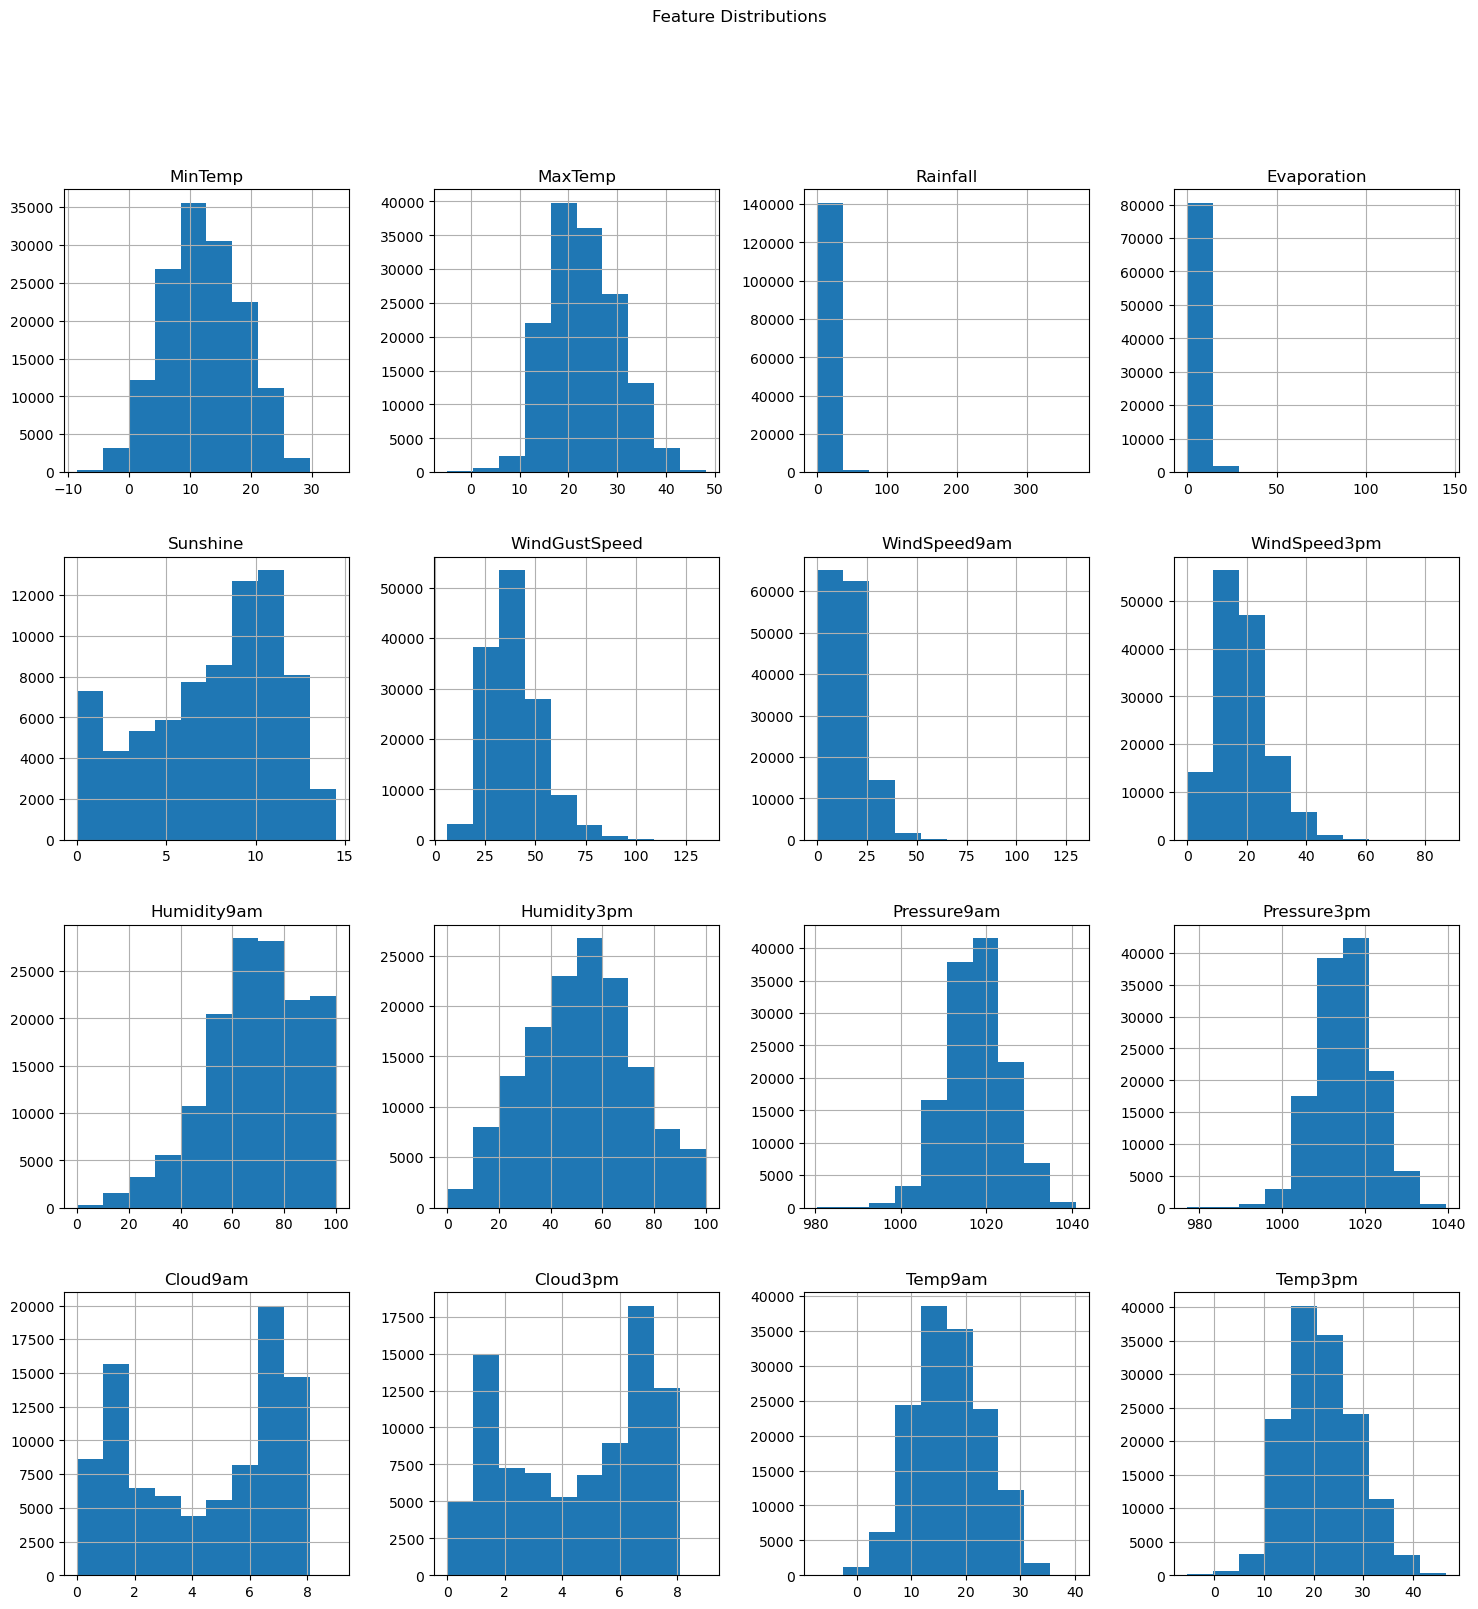

ValueError: could not convert string to float: '2008-12-01'

<Figure size 1600x1400 with 0 Axes>

In [2]:
# Basic column histograms
df.hist(figsize=(18, 18))
plt.suptitle('Feature Distributions')
plt.show()

# Correlation heatmap
plt.figure(figsize=(16, 14))
corr = df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


Comment: Histograms provide a sense of data skewness and outliers; heatmaps reveal feature interdependencies to guide feature selection.

## 3. Feature Selection and Cleaning
Select relevant columns and handle missing values:

In [3]:
columns = [
    'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
    'Humidity9am', 'Humidity3pm', 'Pressure3pm', 'Temp3pm', 'RainToday', 'RainTomorrow'
]
data = df[columns].copy()
data['RainToday'] = data['RainToday'].map({'No': 0, 'Yes': 1})
data['RainTomorrow'] = data['RainTomorrow'].map({'No': 0, 'Yes': 1})
data = data.dropna(subset=['RainTomorrow'])

for col in columns[:-1]:
    data[col].fillna(data[col].median(), inplace=True)


/var/folders/jq/944hrjvd749gpmgdz145sztw0000gn/T/ipykernel_1862/3306632120.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)


Comment: This consolidates all features critical for rainfall prediction and deals with missing entries.

## 4. Train-Test Split
Divide the dataset for unbiased evaluation:

In [5]:
from sklearn.model_selection import train_test_split

X = data.drop('RainTomorrow', axis=1)
y = data['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


## 5. Feature Scaling
Standardize the data, which is crucial for gradient-based modeling:

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 6. Model Building and Training
Set up and fit the logistic regression model:


In [8]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, random_state=42)

## 7. Feature Importance (Recursive Feature Elimination)
Identify which variables matter most:

In [9]:
from sklearn.feature_selection import RFE

rfe = RFE(log_reg, n_features_to_select=5)
rfe.fit(X_train_scaled, y_train)
important_features = X.columns[rfe.support_]
print('Selected Features:', important_features)


Selected Features: Index(['MaxTemp', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm', 'RainToday'], dtype='object')


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Suppose X_train holds your training data as a DataFrame
# and log_reg is your trained LogisticRegression model

# Get absolute values of coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()

# Sort by absolute coefficient and select top 5
top_features = feature_importance.sort_values(
    by='Abs_Coefficient', ascending=False
).head(5)
print(top_features)


         Feature  Coefficient  Abs_Coefficient
5    Humidity3pm     1.241734         1.241734
6    Pressure3pm    -0.486774         0.486774
3  WindGustSpeed     0.472532         0.472532
8      RainToday     0.192588         0.192588
7        Temp3pm     0.164962         0.164962


/var/folders/jq/944hrjvd749gpmgdz145sztw0000gn/T/ipykernel_1862/1298901820.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


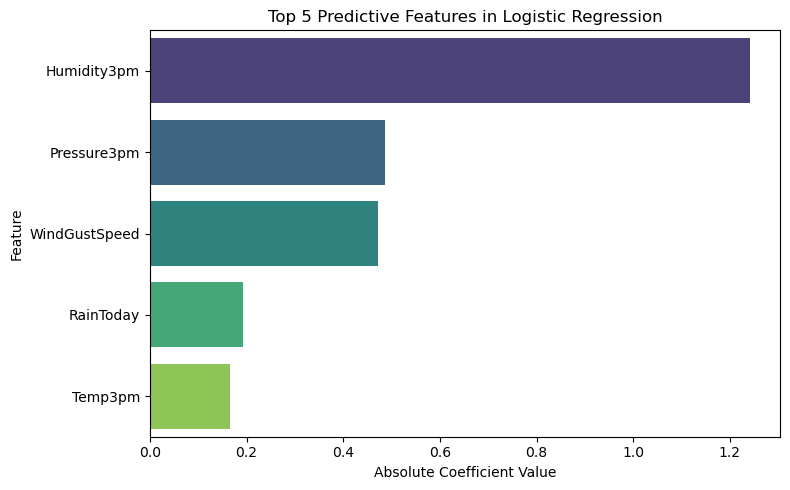

In [15]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_features,
    x='Abs_Coefficient',
    y='Feature',
    palette='viridis'
)
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 5 Predictive Features in Logistic Regression')
plt.tight_layout()
plt.show()


#### Explanation:
- The code ranks features by the absolute value of their logistic regression coefficients, ensuring both positive and negative predictors are considered.
- It then visualizes these features using a horizontal bar plot, making their relative importance easy to interpret.
This approach helps you quickly identify which variables have the strongest effect—positively or negatively—on your target prediction.


     Tip: If you use Recursive Feature Elimination (RFE) or another feature selector, replace X_train.columns above with the list of selected features in the same order as the model’s coefficients.

## 8. Model Evaluation: Confusion Matrix
After making predictions, review the confusion matrix for classification quality:

In [10]:
from sklearn.metrics import confusion_matrix

y_pred = log_reg.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[26120  1460]
 [ 4274  3695]]


Comment: The matrix provides counts for true/false positives and negatives, clarifying error tendencies (e.g., more false positives or negatives).

## 9. Classification Metrics
Evaluate overall performance:

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['No Rain', 'Rain']))


Accuracy: 0.8387015105910152
Precision: 0.7167798254122212
Recall: 0.4636717279457899
F1 Score: 0.5630905211825663
              precision    recall  f1-score   support

     No Rain       0.86      0.95      0.90     27580
        Rain       0.72      0.46      0.56      7969

    accuracy                           0.84     35549
   macro avg       0.79      0.71      0.73     35549
weighted avg       0.83      0.84      0.83     35549



## 10. ROC Curve and AUC
Visualize model discrimination ability across all thresholds:

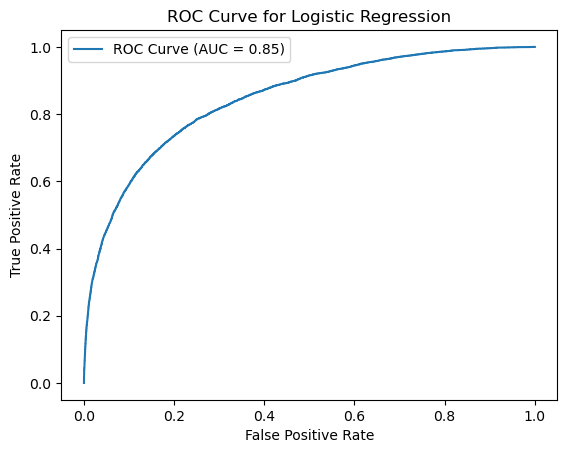

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.show()


The ROC curve for this logistic regression model demonstrates its ability to distinguish between rain/no-rain days at various thresholds.

## 11. Threshold Tuning, Anomalies, and Advanced Optimizations
Adjust the probability cutoff (e.g., try 0.4 instead of the default 0.5) for business-driven precision/recall trade-offs.
Use additional metrics (such as Precision-Recall curves) and investigate misclassified instances (anomalies) to refine the model.
With further code, apply GridSearchCV or cross-validation for hyperparameter tuning, or implement k-fold validation for robust metrics.


Takeaway
Each step, backed by visual outputs and code snippets, provides a clear logic-on-rails workflow from raw data to a reliable, interpretable rainfall prediction engine. Use the snippets and explanations here to create a transparent, reproducible weather forecasting analysis in Python.